In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

## **Regularization**


In [2]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        #print("target shape : ", target.shape)
        mask = torch.nonzero(target == self.padding_idx)
        #print("mask: ", mask, mask.dim())
        if mask.shape[0] > 0:
            #print("padding")
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        #print(true_dist)
        return self.criterion(x,true_dist)


### **Label Smoothing**
학습 중에 우리는 라벨 스무딩(label smoothing) 계수 ϵ<sub>ls</sub> = 0.1을 적용했다 [출처 필요](https://arxiv.org/abs/1512.00567).  
이는 모델이 덜 확신을 가지도록 학습되기 때문에 퍼플렉서티(perplexity)에는 부정적인 영향을 주지만,  
정확도와 BLEU 점수는 향상시킨다.  
  
라벨 스무딩은 **KL 발산 손실(KL divergence loss)** 을 이용해 구현하였다. 원-핫(one-hot) 형태의 타깃 분포 대신,  
정답 단어에 일정한 확신(confidence)을 부여하고 나머지 스무딩 질량(mass)은 전체 어휘에 고르게 분산시킨   
확률 분포를 생성한다.

` 1. Label Smoothing이란 무엇인가요?`  
라벨 스무딩(Label Smoothing)은 딥러닝 모델을 학습할 때 과도하게 확신(confident)하는 경향을 줄이기 위한  
regularization 기법입니다.  

- 일반적으로 분류 문제에서는 정답 클래스에만 1, 나머지에는 0인 one-hot 벡터를 정답(label)으로 사용합니다.
- 그러나 이것은 모델이 학습 데이터에 대해 100% 확신하도록 강요하게 되어, overfitting이나  
generalization 성능 저하의 원인이 될 수 있습니다.  
**라벨 스무딩**은 이 확신을 완화시켜,
   - 정답 클래스에 1 - ϵ,
   - 나머지 클래스에 ϵ / (V - 1)의 확률을 주는 방식입니다.

여기서 ϵ은 smoothing factor (예: 0.1), V는 어휘 수(vocabulary size)입니다.  

예시:  
원래 라벨: [0, 0, 1, 0]  
스무딩 후: [0.033, 0.033, 0.9, 0.033] (ϵ = 0.1, V = 4)  

`2. KL Divergence Loss를 활용한 구현`  
KL 발산(Kullback-Leibler Divergence)은 두 확률 분포 간의 차이를 측정하는 손실 함수입니다.
라벨 스무딩을 적용할 때는 원-핫 분포 대신 스무딩된 확률 분포를 타깃으로 사용하여, 모델 출력 분포와의 차이를 KL Divergence로 계산합니다.  
- 이 방식은 다음과 같은 장점이 있습니다:  
- 모델이 다른 클래스도 어느 정도 가능성이 있다고 생각하도록 유도
    - 학습이 더 안정적이고, **범용성(generalization)**이 좋아짐

`3. Perplexity가 낮아지는 이유`  
Perplexity(당혹도)는 주로 언어 모델의 출력 확률 분포가 얼마나 정답에 집중되어 있는지를 측정합니다.  
라벨 스무딩을 적용하면 모델은 정답 하나에만 집중하지 않고, 다른 클래스에도 일정 확률을 분산합니다.  
따라서 Perplexity는 상대적으로 높아지지만, 이는 모델이 덜 확신하는 방향으로 학습되었기 때문입니다.  
즉, "불확실한 분포" → Perplexity는 나빠짐  

`4. 그럼에도 Accuracy나 BLEU 점수가 좋아지는 이유`  
- 실제로 모델이 정답이 아닌 단어에도 일정한 가능성을 부여하기 때문에,
- 일반화 성능이 향상되고,
- BLEU (번역 품질 측정 지표) 같은 평가에서는 더 좋은 결과를 낼 수 있습니다.
- 특히 희귀 단어 처리나 문맥에서 유연한 판단이 요구되는 경우에 효과적입니다.

✅ 요약  

|항목 |	설명|
|-----|-----|
|목적  |	모델의 과도한 확신을 줄여서 과적합 방지 및 일반화 성능 향상
|적용 방식|	정답 분포를 완전히 one-hot으로 하지 않고 일부 확률을 나머지 클래스에 분산
|장점|	BLEU/Accuracy 개선, 모델의 불확실성 표현, 일반화 능력 향상
|단점|	Perplexity(퍼플렉서티)는 낮아짐 (모델이 확신하지 않기 때문)

`true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)` 코드 분석
----------------------------------------------------------------------------

**scatter_** 는 인플레이스 연산으로, 기존 텐서에 값을 '분산(scatter)"시켜 넣는 함수임.  
구문은 다음과 같음
```
tensor.scatter_(dim, index, src)
```

- `dim`: 값을 흩뿌릴 차원(예: 1-> 열 방향)
- `index` : 위치를 지정하는 텐서
- `src` : 흩뿌릴 값 (스칼라 또는 텐서)
-  `_`가 붙었으므로 원래의 텐서를 수정합니다. (in-place)

**test for LabelSmoothing**  
LabelSmoothing 코드를 라인 단위로 분석해 봄 

In [3]:
size, padding_idx, smoothing=5, 0, 0.4
x = torch.tensor([[0, 0.2, 0.7 , 0.1, 0],
                  [0, 0.2, 0.7, 0.1, 0], 
                  [0, 0.2, 0.7, 0.1, 0]], dtype=torch.float)
y = torch.tensor([2,1,0])

true_dist = x.data.clone()
true_dist.fill_(smoothing / (size - 2))
true_dist.scatter_(1, y.data.unsqueeze(1), 1-smoothing)
true_dist[:, padding_idx] = 0
print(true_dist)

mask = torch.nonzero(y.data == padding_idx)
print(mask)

if mask.dim() > 0:
    print(mask.dim())
    true_dist.index_fill_(0, mask.squeeze(), 0.0)
    print(true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
tensor([[2]])
2
tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [4]:
if mask.dim() > 0:
    print(mask.dim())
    true_dist.index_fill_(0, mask.squeeze(), 0.0)

2


`mask = torch.nonzero(y.data == padding_idx)` : 분석  
----------------------------------------------------

이 코드는 target 텐서에서 padding_idx와 같은 값을 갖는 위치(index)를 찾아주는 코드입니다.  


각 부분 설명
------------
---
1. `target = torch.tensor([2, 1, 0])`  
예를 들어, 이 target은 세 개의 정답 클래스를 가지고 있습니다.  
보통 NLP 등에서 target은 토큰 인덱스 시퀀스를 의미할 수 있습니다.  
여기서 0은 패딩 토큰(예: <pad>)이라고 가정할 수 있습니다.  
예를 들어, padding_idx = 0 이라면 마지막 값이 패딩입니다.  

2. `target.data == padding_idx`  
target == padding_idx는 각 요소가 padding_idx와 같은지 여부를 나타내는 불리언 텐서를 만듭니다.  
예를 들어 padding_idx = 0 이라면 결과는:  
``` python
target == 0 → tensor([False, False, True])
```
>.data는 과거에는 in-place 연산 우회를 위해 쓰였지만, 요즘은 target == padding_idx만 쓰는 게 더 안전하고 권장됩니다.  

3. `torch.nonzero(...)`  
    - `nonzero()`는 `True`인 위치(인덱스) 를 반환합니다.   
    위 예시에서:
    ``` python
    mask = torch.nonzero(target == 0)
    ```
    
    결과는:

    ``` python
    tensor([[2]])
    ````
      
    → 즉, target[2]이 패딩이므로 그 위치 인덱스 [2]가 반환된 것입니다.

4. `전체 예제`
-------------
   
``` python
import torch

target = torch.tensor([2, 1, 0])
padding_idx = 0

mask = torch.nonzero(target == padding_idx)

print(mask)  # tensor([[2]])
```
--- 
5. `실제 사용 예 (NLP)`  
이 구조는 보통 다음과 같은 용도로 쓰입니다:  

- **Loss** 계산 시 **padding** 위치 무시
- **attention mask**나 **sequence mask** 생성

예: `loss.masked_fill(mask, 0)` 또는 `loss = loss[mask == 0].mean()` 등



`true_dist.index_fill_(0, mask.squeeze(), 0.0)` : 분석
------------------------------------------------------

true_dist.index_fill_()는 PyTorch에서 특정 인덱스를 골라서 값을 "채워 넣는" 데 사용되는 함수임  


1. `index_fill_ 기본 개념`:  
``` python
tensor.index_fill_(dim, index, value)
````
- `dim`: 채워 넣을 차원 (예: 0 → row, 1 → column)
- `index`: 채워 넣을 위치 인덱스들 (LongTensor 또는 리스트)
- `value`: 채워 넣을 값 (스칼라)

> _가 붙었으므로 in-place 연산 → 기존 텐서를 직접 수정

2. **전체 코드 맥락 예제**  

In [5]:
import torch

true_dist = torch.tensor([
    [0.1, 0.2, 0.3],
    [0.4, 0.5, 0.1],
    [0.3, 0.1, 0.2]
], dtype=torch.float)

mask = torch.tensor([[2]])  # 예를 들어 target == padding_idx인 위치

print("row direction")
true_dist.index_fill_(0, mask.squeeze(), 0.0)

print(true_dist)

print("coloum direction")
true_dist.index_fill_(1, mask.squeeze(), 0.0)

print(true_dist)

row direction
tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.1000],
        [0.0000, 0.0000, 0.0000]])
coloum direction
tensor([[0.1000, 0.2000, 0.0000],
        [0.4000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000]])


3. **실제로 언제 쓰일까?**  

패딩 위치의 target에는 정답이 없으므로, 그에 해당하는 true_dist를 0으로 채워서 loss에 영향을  
주지 않도록 무력화할 때 사용됩니다.  
즉, label smoothing을 사용할 때 padding 위치도 soft label 분포를 갖고 있긴 하지만,   
그걸 loss에서 무시하고 싶을 때 이렇게 0으로 밀어버립니다

`nn.KLDivLoss(size_average=False)` :
------------------------------------  
PyTorch의 `nn.KLDivLoss(size_average=False)`는 **Kullback-Leibler Divergence (KL divergence)** 를 계산하는 손실 함수입니다.  
이 함수는 두 확률 분포 사이의 차이를 측정하는 데 사용되며, 주로 **soft target**을 사용할 때 등장합니다.  

1. **기본 개념: KL Divergence란?**  
KL Divergence는 두 확률 분포 $𝑃(target)$와 $Q(prediction)$의 차이를 측정합니다:  
$$ D_{KL}(P|Q) = \sum_i P(i)\cdot \log\left(\frac{P(i)}{Q(i)}\right)$$

2. **코드 설명**  

``` python
import torch.nn as nn

loss_fn = nn.KLDivLoss(size_average=False)
```

- `KLDivLoss`: **KL divergence** 손실 함수
- `size_average=False`:  
→ 평균을 내지 않고 모든 loss 값을 합산합니다  
→ PyTorch 0.4 이후에는 reduction='sum' 또는 'mean'을 사용하는 방식으로 변경되었어요.

> 참고: size_average는 이제 deprecated 되었으며, 대신 reduction 인자를 사용하는 것이 최신 방식입니다.


3. **최신식 표현으로 바꾸면?**

``` python
loss_fn = nn.KLDivLoss(reduction='sum')  # 또는 'batchmean', 'none', 'mean'
```

|reduction 값|	의미|
-------------|------|
|'none'|	각 요소의 loss 개별 반환|
|'sum'|	모든 loss 합산|
|'mean'|	전체 평균|
|'batchmean'|	(전체 loss 합) / (batch_size) ← 이게 논문에서 많이 씀|

4. **예제 코드:**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# input: log probability
input = F.log_softmax(torch.tensor([[0.2, 0.8]]), dim=1)  # shape: [1, 2]
# target: probability distribution (must sum to 1)
target = torch.tensor([[0.1, 0.9]])  # shape: [1, 2]

loss_fn = nn.KLDivLoss(reduction='sum')
loss = loss_fn(input, target)

print(loss.item())  # KL divergence 값

0.17240498960018158


In [7]:
input = F.log_softmax(torch.tensor([[0.2, 0.8]]), dim=1)
print(input)

tensor([[-1.0375, -0.4375]])


`Variable(true_dist, requires_grad=False)`
-------------------------------------------
1. `Variable` 이란? (구버전 PyTorch)
- PyTorch 0.4 이전에는 Variable이 텐서와 autograd(자동 미분)를 연결해주는 래퍼였습니다.
- 기본적으로 Variable은 다음과 같이 사용됐습니다:

``` python
from torch.autograd import Variable

x = Variable(torch.tensor([1.0]), requires_grad=True)
```
- 하지만 PyTorch 0.4 이후로는 Tensor 자체가 autograd를 지원하기 때문에 Variable은 deprecated 되었고,   더 이상 필요하지 않습니다.

2. `requires_grad=False` 의미:  
- 이는 해당 텐서가 역전파 과정에서 gradient를 계산하지 않도록 설정한다는 의미입니다.
- 주로 정답 분포(true distribution), mask, 고정된 상수 값 등을 설정할 때 사용합니다.

3. 용도: 정답 분포 (True Distribution)
이 표현은 주로 KLDivLoss, NLLLoss, CrossEntropyLoss와 같은 손실 함수에 사용할 정답 분포를 만들 때 사용됩니다.

> <span style="color: red; font-weight: bold"> Here we can see an example of how the mass is distributed to the words based on confidence.</span>

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


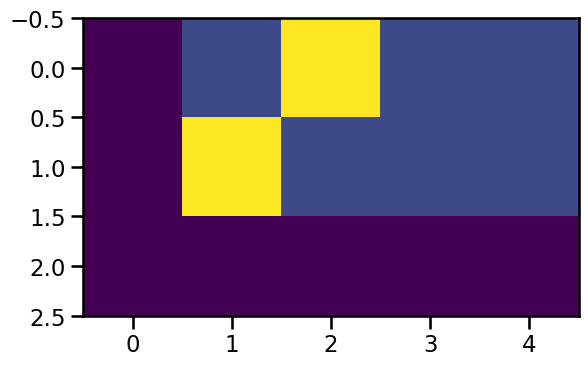

In [8]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
print(crit.true_dist)
None

> <span style="color: red; font-weight: bold"> Label smoothing actually starts to penalize the model if it gets very confident about a given choice.</span>  
라벨 스무딩(label smoothing)은 모델이 특정 선택에 대해 너무 확신을 가지게 되면, 오히려 그것을 페널티(불이익)로 간주하기 시작한다.

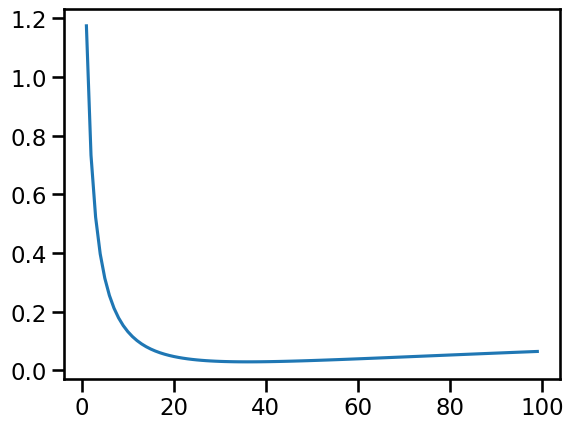

In [9]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 4 * 1
    predict = torch.FloatTensor([[1/d, x / d, 1 / d, 1 / d, 1 / d]])
    #print(predict)
    return crit(predict.log(), torch.LongTensor([1])).item()

#print(loss(1))
    
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])


`loss(x) 함수의 오류를 수정해야 함.`

``` python
 d = x + 3 * 1
predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
```

         ⇩

``` python
 d = x + 4 * 1
predict = torch.FloatTensor([[1/d, x / d, 1 / d, 1 / d, 1 / d]])
```